# Plain neural network training
As in https://github.com/carrascomj/gcn-prot/, train a plain neural network with the data.

In [1]:
import nnbody
import torch

import torch.nn.functional as F
from os.path import join, pardir
from sklearn.metrics import confusion_matrix

In [2]:
ROOT_DIR = pardir

## Initialize Data

In [3]:
largest = nnbody.features.get_longest(join(ROOT_DIR, "data", "features", "bioil", "graph"))
print(f"Largest protein has {largest} aminoacids")

Largest protein has 114 aminoacids


In [4]:
data_path = join(ROOT_DIR, "data", "features", "bioil")

In [5]:
train, valid, test = nnbody.features.get_datasets(
    data_path=data_path,
    nb_nodes=largest,
    task_type="regression",
    nb_classes=1,
    split=[0.9, 0.05, 0.05],
    seed=42,
    augment=1, # data augmentation factor x3
)

CLASS[COUNTS]:  64.2740611320203 1
CLASS[COUNTS]:  64.54440043719161 1
CLASS[COUNTS]:  64.60213329495033 1
CLASS[COUNTS]:  64.6022355897041 1
CLASS[COUNTS]:  64.85049291281784 1
CLASS[COUNTS]:  64.90446569575211 1
CLASS[COUNTS]:  65.36516530364887 1
CLASS[COUNTS]:  65.8322851810582 1
CLASS[COUNTS]:  66.03886487617592 1
CLASS[COUNTS]:  66.10742124691461 1
CLASS[COUNTS]:  66.12014665791064 1
CLASS[COUNTS]:  66.26512476761867 1
CLASS[COUNTS]:  66.3767922531563 1
CLASS[COUNTS]:  66.75857093819434 1
CLASS[COUNTS]:  66.98805656010116 1
CLASS[COUNTS]:  67.0603119695099 1
CLASS[COUNTS]:  67.06117615393474 1
CLASS[COUNTS]:  67.27927533996383 1
CLASS[COUNTS]:  67.3411261781532 1
CLASS[COUNTS]:  67.414076858983 1
CLASS[COUNTS]:  67.44000696067964 1
CLASS[COUNTS]:  67.4502966200309 1
CLASS[COUNTS]:  67.45373564704543 1
CLASS[COUNTS]:  67.5359812365809 1
CLASS[COUNTS]:  67.7736808858947 1
CLASS[COUNTS]:  67.85506673879446 1
CLASS[COUNTS]:  68.03238677978517 1
CLASS[COUNTS]:  68.07933095526477 1
CLA

Since we have a small dataset, we can store everything in memory. 

In [6]:
train.flush()
test.flush()
valid.flush()

In [7]:
print(f"Train: {len(train)}\nTest: {len(test)}\nValidation: {len(valid)}")

Train: 50
Test: 3
Validation: 3


## FFNN

Each instance in the dataset retrieves a list of four matrices:

* feature matrix: 29 x 185. This corresponds to the aminoacid type (one-hot encoded vector of length 23), residue depth, residue orientation and 4 features encoding the positional index with a sinusoidal transformation.
* coordinates: 3 x 185. x,y,z coordinates of every aminoacid in the crystal (centered) (not used for FFNN)
* mask: to be applied to the adjacency to discard ill-identified aminoacids.
* y: 2 labels, Kras/Hras.


Instatiate the NN model, the optimizer and the criterion.

In [8]:
model = nnbody.models.FFNN(
    feats=29,             # features in feature matrix
    hidden=[60, 101, 34],      # number of neurons in convolutional layers (2 in this case)
    #hidden_norm=25,
    label=1,              # regression (features on y = 1)
    nb_nodes=largest,     # for last layer
    dropout=0,
    #D=1,
    cuda=False             # required for sparsize and fit_network
)

In [9]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.MSELoss()

## FFNN Training loop¶

Epoch 1 (0/1)            

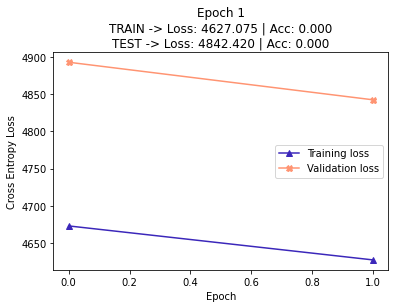

Epoch 2 (0/1)            

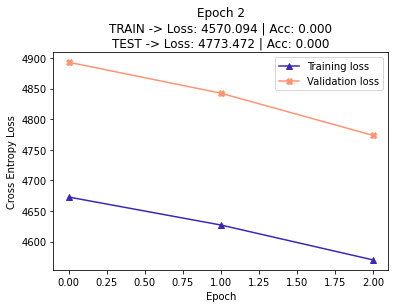

Epoch 3 (0/1)            

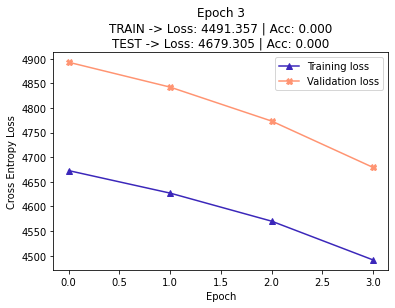

Epoch 4 (0/1)            

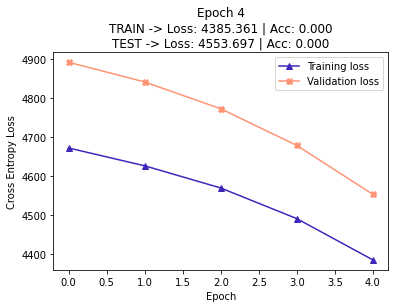

Epoch 5 (0/1)            

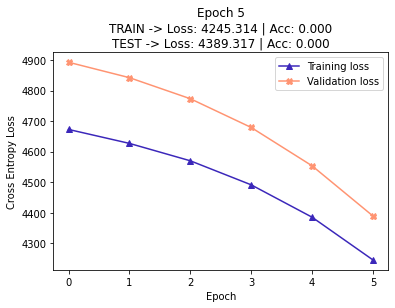

Epoch 6 (0/1)            

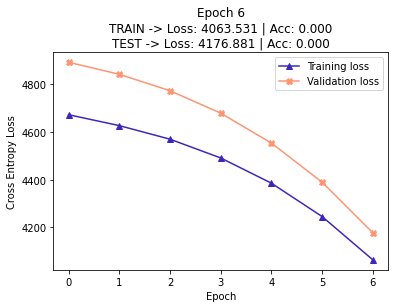

Epoch 7 (0/1)            

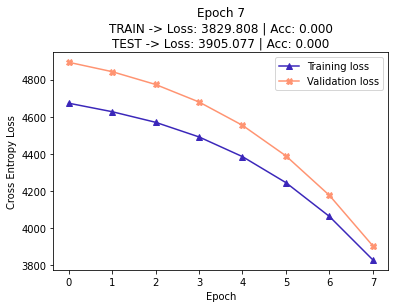

Epoch 8 (0/1)            

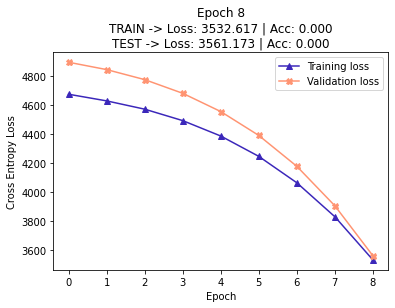

Epoch 9 (0/1)            

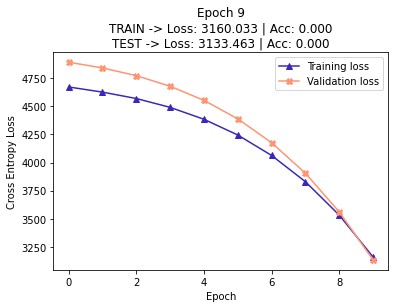

In [10]:
save_path = join(ROOT_DIR, "models", "01_FFNN_weigths.pt")
model = nnbody.models.fit_network(
    model, train, test, optimizer, criterion,
    batch_size=300,   # 7 batches per epoch
    epochs=10,
    debug=True,      # will print progress of epochs
    plot_every=1,    # loss plot/epoch
    save=save_path   # best weights (test set) will be saved here
)

In [12]:
model.load_state_dict(torch.load(join(ROOT_DIR, "models", "01_FFNN_weigths.pt")))

<All keys matched successfully>

## FFNN Validation


In [14]:
validator = nnbody.models.Validation(model, valid)
validator.validate()